<a href="https://colab.research.google.com/github/TarikSalles/TensorFlow-Advanced-Techniques-Specialization/blob/main/GAN_profunda_com_dataset_de_cachorros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GAN profunda para criação de faces de cachorros

## Imports

In [6]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from zipfile import ZipFile
import cv2


In [ ]:
!unzip dog.zip

## Funções Uteis

In [40]:
def plot_multiple_images_tf(X_train, amount_images, n_cols=None):
    random_indices = np.random.choice(X_train.shape[0], amount_images, replace=False)
    random_indices = tf.convert_to_tensor(random_indices, dtype=tf.int32)
    images = tf.gather(X_train, random_indices)

    images = (images + 1) / 2

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    plt.figure(figsize=(n_cols * 3, n_rows * 3))

    for index, image_tensor in enumerate(images):
        image = image_tensor.numpy()
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

    plt.show()


In [37]:
import os
import cv2
import numpy as np
import tensorflow as tf

def load_and_preprocess_images(target_size=(128, 128)):
    train_dir = '/content/dogs/data/train/animal animal_faces dog dog_face'

    X_train = []

    for image_name in os.listdir(train_dir):
        image_path = os.path.join(train_dir, image_name)

        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)

        img = img.astype(np.float32) / 127.5 - 1

        X_train.append(img)

    X_train = tf.convert_to_tensor(X_train)

    return X_train

X_train = load_and_preprocess_images()


In [38]:
len(X_train)

5118

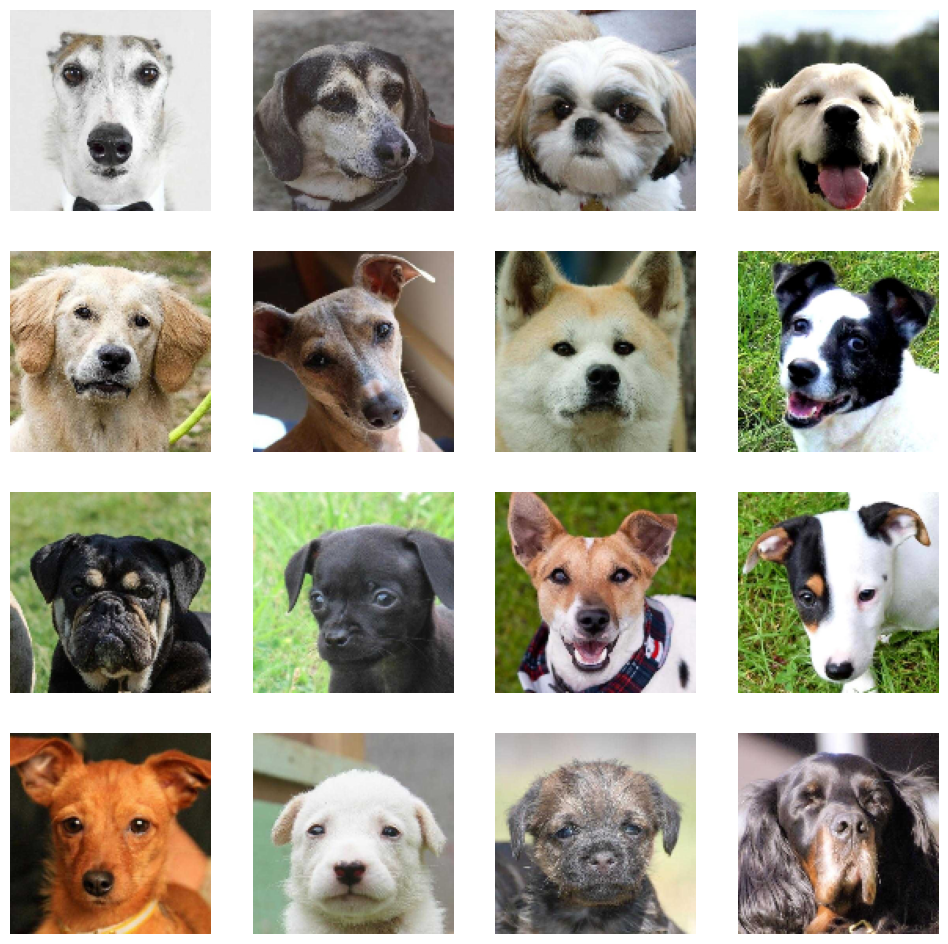

In [41]:
plot_multiple_images_tf(X_train,16, n_cols=4)

In [42]:
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

### Gerador

In [58]:
random_normal_dimensions = 1024

generator = keras.models.Sequential([
    keras.Input(shape=(random_normal_dimensions,)),

    keras.layers.Dense(8*8*256),
    keras.layers.Reshape([8, 8, 256]),

    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="tanh")
])


In [59]:
generator.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 16384)               │      16,793,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_7 (Reshape)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_29                  │ (None, 16, 16, 128)         │         819,328 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_30                  │ (None, 32, 32, 64)          │         204,864 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_31                  │ (None, 64, 64, 32)          │          51,232 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_32                  │ (None, 128, 128, 3)         │           2,403 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,872,323 (68.18 MB)

 Trainable params: 17,871,875 (68.18 MB)

 Non-trainable params: 448 (1.75 KB)

### Passando barulho para gerador

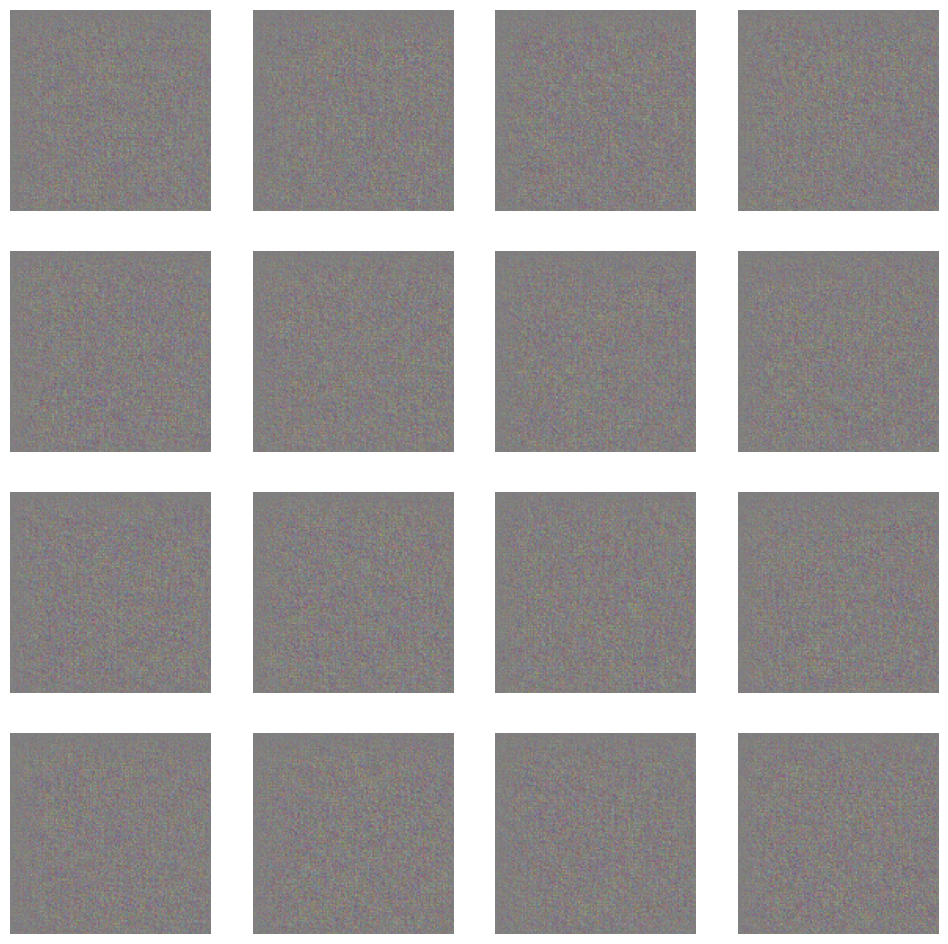

In [60]:
test_noise = tf.random.normal([16, random_normal_dimensions])

test_image = generator(test_noise)

plot_multiple_images_tf(test_image, 16, n_cols=4)

### Discriminador

In [61]:
discriminator = keras.models.Sequential([
    keras.Input(shape=[128, 128, 3]),

    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(512, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),

    keras.layers.Dense(1, activation="sigmoid")
])


In [62]:
gan = keras.models.Sequential([generator, discriminator])

In [63]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Treinando o modelo


* Fase 1 - treina o discriminador com dados reais e falsos
* Fase 2 - treina o gerador



In [67]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):


    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print("Época {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:
            batch_size = real_images.shape[0]

            # Fase 1
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            fake_images = generator(noise)

            mixed_images = tf.concat([fake_images, real_images], axis=0)

            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            discriminator.trainable = True

            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Fase 2
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            generator_labels = tf.constant([[1.]] * batch_size)

            discriminator.trainable = False

            gan.train_on_batch(noise, generator_labels)
        plot_multiple_images_tf(fake_images, 8)
        plt.show()

In [ ]:
train_gan(gan, dataset, random_normal_dimensions, n_epochs=50)

### Depois de treino de 50 épocas

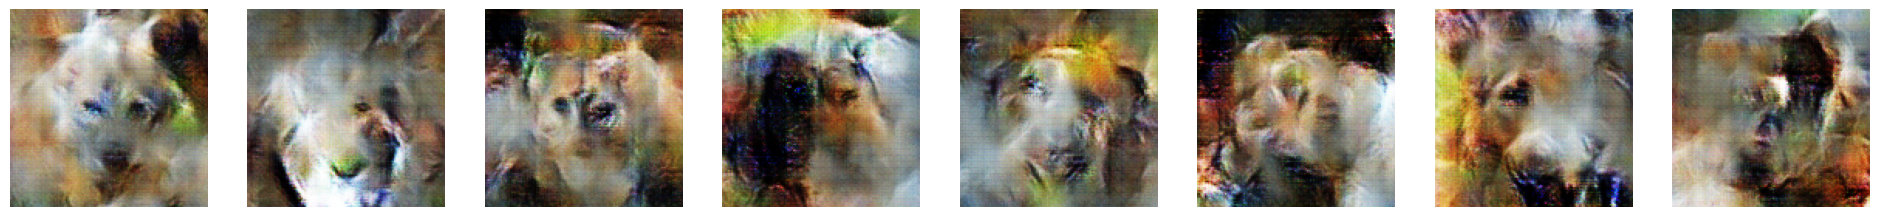

In [72]:
noise = tf.random.normal(shape=[16, random_normal_dimensions])
fake_images = generator(noise)
plot_multiple_images_tf(fake_images, 8)

### Como visto, a GAN profunda foi capaz de gerar imagens que de certa forma lembram cães, posuem algumas características porém praticamente irreconhecíveis. Por ser um dataset muito variado com imagens que, teoricamente, não se repetem, talvez seja uma tarefa muito complexa considerando as praticamente infinitas raças e misturas de cachorros apresentados no dataset, muitas vezes com poucas semelhanças entre si.